# Using Pretrained Networks - VGG19 to improve model

__objective:__ Use Keras to implement feature engineering and fine tuning on a pre-trained model 

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [2]:
# import os 
# print(os.listdir("/content/gdrive/My Drive/Flatiron_school/Flatiron_MOD_4/Convolutional_Neural_Networks/dsc-building-a-cnn-from-scratch-onl01-dtsc-ft-030220/chest_xray_downsampled"))

In [3]:
# import datetime

# start = datetime.datetime.now()

In [4]:
import os, shutil
import time
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img

np.random.seed(123)

Using TensorFlow backend.


In [5]:
# select when running google colab
# train_folder = '/content/gdrive/My Drive/Flatiron_school/Flatiron_MOD_4/Convolutional_Neural_Networks/dsc-building-a-cnn-from-scratch-onl01-dtsc-ft-030220/chest_xray_downsampled/train'
# test_folder = '/content/gdrive/My Drive/Flatiron_school/Flatiron_MOD_4/Convolutional_Neural_Networks/dsc-building-a-cnn-from-scratch-onl01-dtsc-ft-030220/chest_xray_downsampled/test'
# val_folder = '/content/gdrive/My Drive/Flatiron_school/Flatiron_MOD_4/Convolutional_Neural_Networks/dsc-building-a-cnn-from-scratch-onl01-dtsc-ft-030220/chest_xray_downsampled/val'

# select when running local machine
train_folder = 'data/train'
test_folder = 'data/test'
val_folder = 'data/val'

In [6]:
datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 10

## VGG19: Feature extraction

In [7]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(150, 150, 3))

In [8]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [9]:
def extract_features(directory, sample_amount):
    features = np.zeros(shape=(sample_amount, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_amount))
    generator = datagen.flow_from_directory(
        directory, target_size=(150, 150), 
        batch_size = 10, 
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = cnn_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch 
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i = i + 1
        if i * batch_size >= sample_amount:
            break
    return features, labels

In [10]:
# You should be able to divide sample_amount by batch_size
ntrain=5216
nval=16
ntest=824
train_features, train_labels = extract_features(train_folder, ntrain) 
validation_features, validation_labels = extract_features(val_folder, nval) 
test_features, test_labels = extract_features(test_folder, ntest)

train_features = np.reshape(train_features, (ntrain, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (nval, 4 * 4 * 512))
test_features = np.reshape(test_features, (ntest, 4 * 4 * 512))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 824 images belonging to 2 classes.


In [11]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=11,
                    batch_size=10,
                    validation_data=(validation_features, validation_labels))

Train on 5216 samples, validate on 16 samples
Epoch 1/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.1624 - acc: 0.9337 - val_loss: 0.1581 - val_acc: 0.9375
Epoch 2/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0932 - acc: 0.9640 - val_loss: 0.4144 - val_acc: 0.8125
Epoch 3/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0753 - acc: 0.9684 - val_loss: 1.0825 - val_acc: 0.7500
Epoch 4/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0694 - acc: 0.9711 - val_loss: 0.0865 - val_acc: 0.9375
Epoch 5/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0604 - acc: 0.9785 - val_loss: 0.2515 - val_acc: 0.9375
Epoch 6/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0531 - acc: 0.9824 - val_loss: 0.2446 - val_acc: 0.8750
Epoch 7/11
5216/5216 [==============================] - 10s 2ms/step - loss: 0.0513 - acc: 0.9827 - val_loss: 0.3040 - val_acc: 0.8750
Epoch 8/1

In [12]:
results_test = model.evaluate(test_features, test_labels)
results_test

824/824 [==============================] - 0s 132us/step


[2.3544136308929295, 0.6917475733942199]

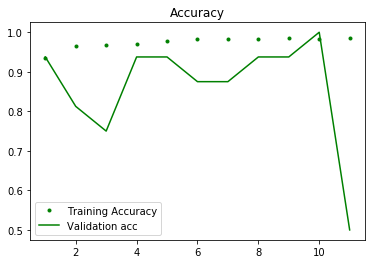

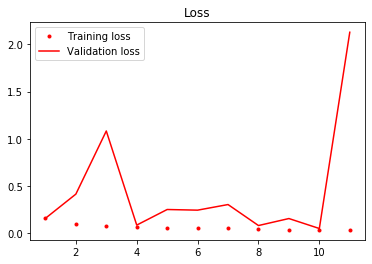

In [13]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

Using VGG-19 you're able to get test set performance up to almost 69%. not really impressive!

## Adding further dense layers

overview of the process:
* Add the pretrained model as the first layer
* Add some dense layers for a classifier on top
* Freeze the convolutional base (all of the weights associated with base layer(s) will remain unchanged through the optimization process)
* Train the model

__Freezing the base is important as you wish to preserve the features encoded in this CNN base. Without this, the volatile gradients will quickly erase the useful features of the pretrained model.__

In [15]:
model = models.Sequential()
model.add(cnn_base)
# model.add(layers.Flatten())
# model.add(layers.Dense(132, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

## Freezing

Now that you've designed the model architecture, you'll freeze the base. With this, learning to check whether layers are frozen or not is a valuable skill.

In [16]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, you can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 True
flatten_1 True
dense_3 True
dropout_1 True
dense_4 True
dropout_2 True
dense_5 True
dropout_3 True
dense_6 True
40


Freezing a layer is very straightforward: set the `trainable` attribute to False.

In [17]:
cnn_base.trainable = False

A quick sanity check is also prudent and verifies that the base model is indeed frozen:

In [18]:
# You can check whether a layer is trainable (or alter its setting) through the layer.trainable attribute
for layer in model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, we can check how many trainable weights are in the model
print(len(model.trainable_weights))

vgg19 False
flatten_1 True
dense_3 True
dropout_1 True
dense_4 True
dropout_2 True
dense_5 True
dropout_3 True
dense_6 True
8


## data augmentation

Define the training-validation-test sets (now with data augmentation).

In [19]:
# Get all the data in the directory split/train (5216 images), and reshape them
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_folder,  
                                                    target_size=(150, 150),  
                                                    batch_size= 20, 
                                                    class_mode= 'binary') 

# Get all the data in the directory split/validation (16 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,  
                                                                       target_size=(150, 150),  
                                                                       batch_size=20, 
                                                                       class_mode='binary')

# Get all the data in the directory split/test (824 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,  
                                                                        target_size=(150, 150), 
                                                                        batch_size=824,
                                                                        class_mode='binary')

test_images, test_labels = next(test_generator)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 824 images belonging to 2 classes.


__Now let's Compile And fit the model__

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [21]:
# This cell may take several minutes to run
history = model.fit_generator(train_generator,
                              steps_per_epoch=80,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=10)

Epoch 1/10
80/80 [==============================] - 184s 2s/step - loss: 0.7439 - acc: 0.6303 - val_loss: 0.8593 - val_acc: 0.5000
Epoch 2/10
80/80 [==============================] - 182s 2s/step - loss: 0.6415 - acc: 0.6713 - val_loss: 0.7382 - val_acc: 0.5000
Epoch 3/10
80/80 [==============================] - 182s 2s/step - loss: 0.5572 - acc: 0.7294 - val_loss: 0.7171 - val_acc: 0.5000
Epoch 4/10
80/80 [==============================] - 182s 2s/step - loss: 0.5310 - acc: 0.7381 - val_loss: 0.6562 - val_acc: 0.6250
Epoch 5/10
80/80 [==============================] - 182s 2s/step - loss: 0.4919 - acc: 0.7613 - val_loss: 0.5992 - val_acc: 0.6250
Epoch 6/10
80/80 [==============================] - 182s 2s/step - loss: 0.4517 - acc: 0.7728 - val_loss: 0.5910 - val_acc: 0.6250
Epoch 7/10
80/80 [==============================] - 181s 2s/step - loss: 0.4144 - acc: 0.7981 - val_loss: 0.5535 - val_acc: 0.6875
Epoch 8/10
80/80 [==============================] - 182s 2s/step - loss: 0.4283 - a

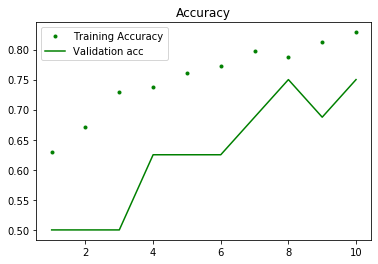

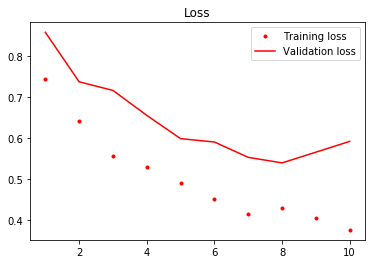

In [22]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

## Fine Tuning the model

Now let's further fine tune the weights of the most abstract layers of the convolutional base. 

- first freeze the entire convolutional base
- tune the fully connected classifier that sits on top of the pretrained convolutional base. 

Thus we can expect a relatively strong accuracy and you can fine tune the weights of the last few layers of the convolutional base. 

Unfreezing initial layers of the convolutional base will typically not produce substantial gains as these early layers learn simple representations such as colors and edges which are useful in all forms of image recognition, regardless of application.   

Recall the model's architecture: 

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
__________

And you can also further investigate the borrowed convolutional base:

In [25]:
cnn_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## further Fine Tuning:

- unfreeze a few of the deeper layers from this base and further fine tune them to our problem scenario. 
- This part is be particularly helpful where adapted models span new domain categories such as the Xray dataset that was never seen in the VGG19 model. 
- when the problem domain is substantially different, additional gains are more likely in adjusting these more abstract layers of the convolutional base. 

In [26]:
cnn_base.trainable = True

Let's refreeze all layers up to a __block5_conv1__ layer. Here we are  unfreezing the final *block* of layers.

In [27]:
cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Finally, we must recompile our model before fitting.

In [28]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(lr=1e-4), 
              metrics=['accuracy'])

Afterwards, we can then fit the model as usual.

In [29]:
# several parameter sets were tested at this point. 
history = model.fit_generator(train_generator,
                              steps_per_epoch=120,
                              epochs=10,
                              validation_data=val_generator,
                              validation_steps=60)

Epoch 1/10
120/120 [==============================] - 338s 3s/step - loss: 0.5030 - acc: 0.7389 - val_loss: 0.6658 - val_acc: 0.5000
Epoch 2/10
120/120 [==============================] - 335s 3s/step - loss: 0.3961 - acc: 0.8100 - val_loss: 0.5529 - val_acc: 0.8125
Epoch 3/10
120/120 [==============================] - 338s 3s/step - loss: 0.3727 - acc: 0.8479 - val_loss: 0.5151 - val_acc: 0.8750
Epoch 4/10
120/120 [==============================] - 335s 3s/step - loss: 0.3826 - acc: 0.8692 - val_loss: 0.6930 - val_acc: 0.6250
Epoch 5/10
120/120 [==============================] - 334s 3s/step - loss: 0.3083 - acc: 0.8784 - val_loss: 4.6680 - val_acc: 0.6250
Epoch 6/10
120/120 [==============================] - 335s 3s/step - loss: 0.3743 - acc: 0.8271 - val_loss: 4.0022 - val_acc: 0.6250
Epoch 7/10
120/120 [==============================] - 333s 3s/step - loss: 0.4125 - acc: 0.8208 - val_loss: 2.5850 - val_acc: 0.7500
Epoch 8/10
120/120 [==============================] - 334s 3s/step - 

In [30]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

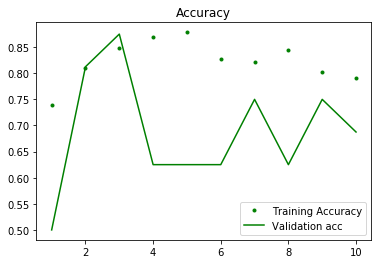

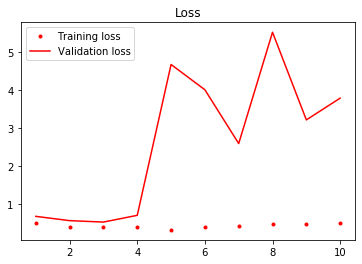

In [31]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'g.', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'r.', label='Training loss')
plt.plot(epch, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
plt.show()

## Final Evaluation



In [ ]:
# 

# test_generator = test_datagen.flow_from_directory(test_dir,
#                                                   target_size=(150, 150),
#                                                   batch_size=20,
#                                                   class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


## Summary

Starting from th e VGG19 base model our study got the accuracy as 79% and validation accuracy as 68%. Thus, transfer learning has not yeilded better results for the Xray dataset